In [1]:
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sktime
from tsai.data.external import get_UCR_data, get_Monash_regression_data
from tsai.models.MINIROCKET import *
# from sklearn.preprocessing import  MinMaxScaler
# from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

# import tensorflow as tf
# from keras.optimizers import  Adam
# from keras.models import Sequential
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import Dense, Activation, Flatten

In [24]:
warnings.filterwarnings(action='ignore', category=UserWarning)

df = pd.read_excel('./DATASET.xlsx')
df.rename(columns={'Unnamed: 0':'Section'}, inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Section  101 non-null    object 
 1   year     1009 non-null   int64  
 2   Para-1   1009 non-null   float64
 3   Para-2   1009 non-null   float64
 4   Para-3   1009 non-null   float64
 5   Para-4   1009 non-null   float64
 6   Para-5   1009 non-null   int64  
 7   Para-6   1009 non-null   int64  
 8   Para-7   1009 non-null   int64  
 9   Para-8   1009 non-null   int64  
 10  Para-9   1009 non-null   float64
 11  Para-10  1009 non-null   float64
 12  Para-11  1009 non-null   float64
 13  Para-12  1009 non-null   int64  
 14  Para-13  1007 non-null   float64
dtypes: float64(8), int64(6), object(1)
memory usage: 118.4+ KB
None


In [25]:
def check_null(df):
    null_entries = df.loc[:,'year':].isnull().any(axis=1)
    count = null_entries.sum()
    print(f'Null Values Found: {count}')
    if count>0:
        print(df[null_entries])
        print()
    return count

In [26]:
count = check_null(df)
if count>0:
    print('Filling Null Values')
    df.fillna(method='bfill',inplace=True)
    count = check_null(df)

Null Values Found: 2
    Section  year  Para-1  Para-2  Para-3  Para-4  Para-5  Para-6  Para-7  \
190  Sec_20     1   454.6   145.6    21.7     0.0       3     106    3650   
260  Sec_27     1   563.9   336.6    21.3     0.0       4     106    6800   

     Para-8  Para-9  Para-10  Para-11  Para-12  Para-13  
190     730     0.0      0.0      0.0        0      NaN  
260    1600     0.0      0.0      0.0        0      NaN  

Filling Null Values
Null Values Found: 0


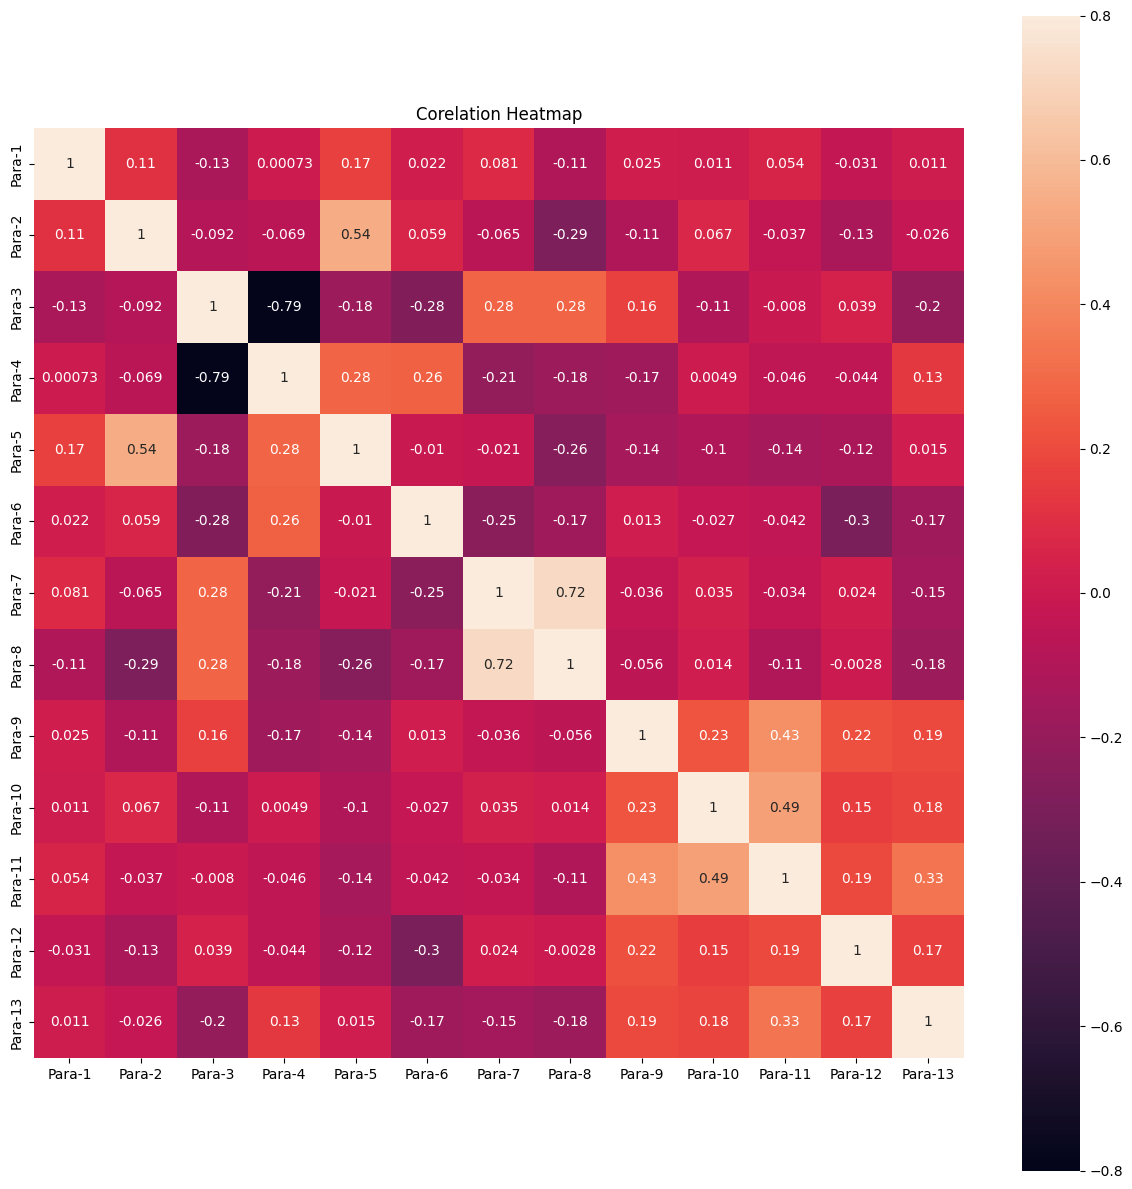

In [27]:
C_mat = df.loc[:,'Para-1':].corr()
fig = plt.figure(figsize = (15,15))
plt.title('Corelation Heatmap')
sns.heatmap(C_mat, vmax = 0.8, vmin = -0.8,  square = True, annot=True)
plt.show()

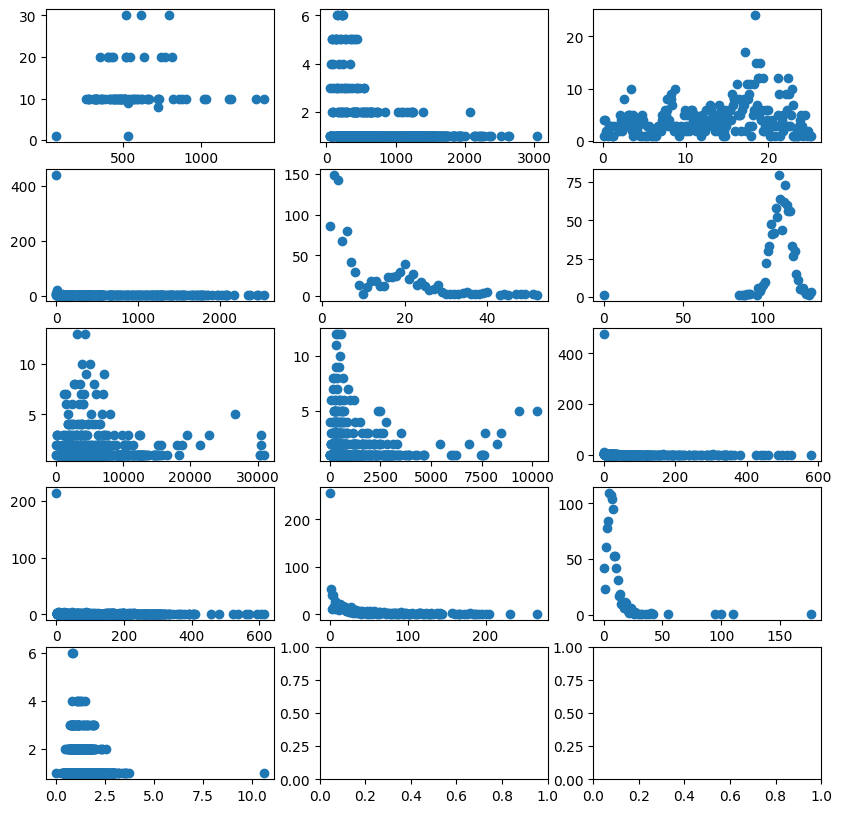

In [42]:
fig, axs = plt.subplots(5, 3, figsize=(10,10))
x, y = 0,-1
for i in range(13):
    x = i//3
    y = i%3
    col = df.columns[i+2]
    axs[x,y].scatter(df[col].value_counts().index, df[col].value_counts())

In [29]:
df.rename(columns={'Unnamed: 0':'Section'}, inplace=True)
df['Section'].ffill(axis=0, inplace=True)
df_sections = df.groupby('Section', dropna=False)

print(f'Grouped dataframe by sections\nDataFrame Size: {len(df)}\nGroups: {len(df_sections)}')

Grouped dataframe by sections
DataFrame Size: 1009
Groups: 101


In [30]:
info_cols = ['Unique', 'Unique-Total Ratio', 'Top Unique ratio', 'Categorical']
info = pd.DataFrame(columns=info_cols)
for col in df.loc[:,'Para-1':].columns:
    unique = df[col].nunique()
    total = df[col].count()
    ratio = df[col].value_counts(normalize=True).head(20).sum()
    temp = pd.DataFrame(data=[[unique, unique/total, ratio, ratio>0.8]], index=[col], columns=info_cols)
    info = pd.concat([info, temp])
# info.index = df.loc[:,'Para-1':].columns
print('Parameter Analysis')
print(info)

Parameter Analysis
        Unique  Unique-Total Ratio  Top Unique ratio Categorical
Para-1      85            0.084242          0.376611       False
Para-2     811            0.803766          0.105055       False
Para-3     230            0.227948          0.238850       False
Para-4     425            0.421209          0.540139       False
Para-5      47            0.046581          0.874133        True
Para-6      42            0.041625          0.917740        True
Para-7     626            0.620416          0.160555       False
Para-8     529            0.524281          0.162537       False
Para-9     364            0.360753          0.562934       False
Para-10    661            0.655104          0.273538       False
Para-11    140            0.138751          0.650149       False
Para-12     40            0.039643          0.959366        True
Para-13    748            0.741328          0.073340       False


In [9]:
# scalar = MinMaxScaler()
# for col in df.loc[:,'Para-1':'Para-8'].columns:
#     # if info.loc[col,'Categorical']==True:
#     #     continue
#     df[col] = scalar.fit_transform(df[[col]])
# for col in df.loc[:,'Para-9':].columns:
#     # if info.loc[col,'Categorical']==True:
#     #     continue
#     df[col] = scalar.fit_transform(df[[col]])

In [31]:
x_train, x_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for section in list(df_sections):
    section[1].reset_index(inplace=True)
    x_train = pd.concat([x_train, section[1].loc[:len(section[1])-2,'Para-1':'Para-8']], ignore_index=True)
    y_train = pd.concat([y_train, section[1].loc[:len(section[1])-2,'Para-9':]], ignore_index=True)
    x_test = pd.concat([x_test, section[1].loc[len(section[1])-1,'Para-1':'Para-8']], ignore_index=True, axis=1)
    y_test = pd.concat([y_test, section[1].loc[len(section[1])-1,'Para-9':]], ignore_index=True, axis=1)

x_test = x_test.T.apply(pd.to_numeric)
y_test = y_test.T.apply(pd.to_numeric)
inp_size = x_train.shape[1]
target_size = y_train.shape[1]

print(f'Train Test Division\n\
Input data size: {inp_size}\n\
Target data size: {target_size}\n\
X-Train data entries: {x_train.shape}\n\
Y-Train data entries: {y_train.shape}\n\
X-Test data entries: {x_test.shape}\n\
Y-Test data entries: {y_test.shape}\n')

# train = df.loc[:,'Para-1':'Para-8']
# target = df.loc[:,'Para-9':]
# x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.1, random_state=42)
# train test split

Train Test Division
Input data size: 8
Target data size: 5
X-Train data entries: (908, 8)
Y-Train data entries: (908, 5)
X-Test data entries: (101, 8)
Y-Test data entries: (101, 5)



In [36]:
dsid = 'AppliancesEnergy'
X_train, y_train, X_valid, y_valid = get_Monash_regression_data(dsid)   # Download the UCR dataset

119it [00:08, 13.55it/s]
66it [00:03, 16.92it/s] 


In [38]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
print(type(X_train))

(95, 24, 144) (42, 24, 144) (95,) (42,)
<class 'numpy.memmap'>


In [16]:
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = MiniRocketRegressor(scoring=rmse_scorer, verbose=True)
# sktime.timer.start(False)
model.fit(x_train, y_train)
# t = timer.stop()
y_pred = model.predict(x_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'valid rmse: {rmse:.5f} time: {t}')

[Pipeline]  (step 1 of 2) Processing minirocketmultivariate, total=   0.7s


ValueError: Found input variables with inconsistent numbers of samples: [1, 908]

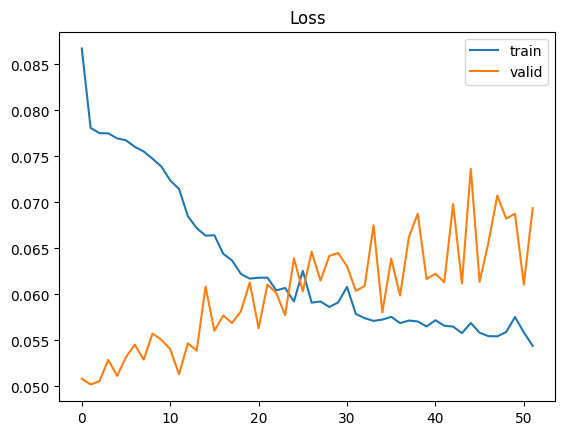

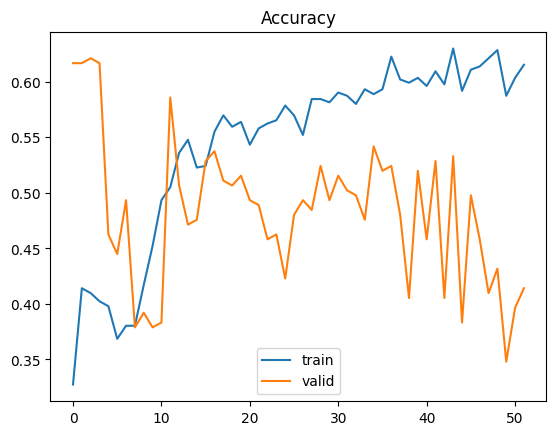

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show()

In [ ]:
# NN_model.load_weights(best_model)
# NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

# predictions = NN_model.predict(x_test)
# accr = model.evaluate()

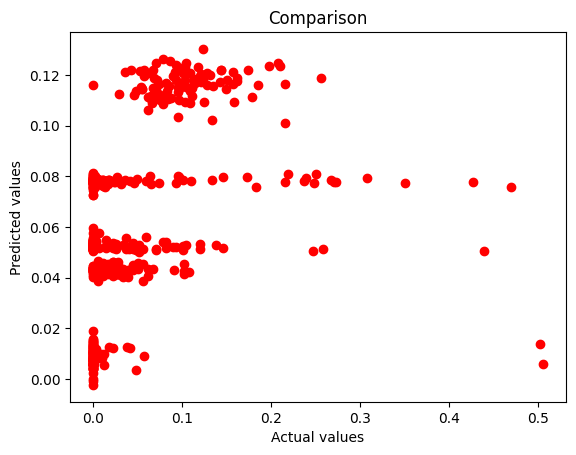

R Square: -0.177
Mean Absolute Error: 0.044
RMSE: 0.064
29/29 [==============================] - 0s 2ms/step
-0.09928523532223284


In [ ]:
predictions = NN_model.predict(x_test, verbose=0)
plt.title('Comparison')
plt.plot(y_test, predictions, 'ro')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

r2 = r2_score(y_pred=predictions, y_true=y_test)
mae = mean_absolute_error(y_pred=predictions, y_true=y_test)
rmse = mean_squared_error(y_pred=predictions, y_true=y_test, squared=False)
print(f'R Square: {r2:.3f}\nMean Absolute Error: {mae:.3f}\nRMSE: {rmse:.3f}')
predictions = NN_model.predict(x_train)
r2 = r2_score(y_pred=predictions, y_true=y_train)
print(r2)